# Finetuning the SKU110K dataset

This notebook is based on the pytorch tutorial for transfer learning:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network. This can be pretrained on imagenet
   or on our own dataset with SSL pretraining.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained. (this is the fine-tuning step)

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion #interactive mode, show plt's on creation

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

## Loading the data
We will use torchvision and torch.utils.data packages for loading the
data.
- specifying the transforms for train and val sets 
- creating dataset objects
- creating dataloader objects
- extracting the class names
- setting up the device being used for training [cpu/cuda:0]

In [3]:
# Dictionary with data augmentation and normalization for training and validation
# normalization and other augmentations could still be added...
# transforms.CenterCrop(224) can also be used instead of RandomResizedCrop(224)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #resnet50 typically takes a 224x224 image as input
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),  #resnet50 typically takes a 224x224 image as input
        transforms.ToTensor(),
    ]),
}

###directory to the (annotated) dataset for finetuning###
data_dir = 'data/sku110k_ft'
#dictionary with train and validation datast objects (torchvision.datasets.ImageFolder(path,transforms))
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}

#dictionary with train and validation dataloader objcts (torch.utils.data.DataLoader(dataset, ...))
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=2) for x in ['train', 'val']}

#dictionary with the dataset sizes (how many images they contain for training and validation)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(f"Dataset sizes: {dataset_sizes}",end="\n\n")

#extracting the class names for classifciation with the dataset object (dataset.classes attribute)
class_names = image_datasets['train'].classes
print(f"class_names: {class_names}", end="\n\n")
#The classes are: [ordered alphabetically]
#The index represents the corresponding output neuron that represent how lickely it classified that product
# 0 -> 'coca_cola'
# 1 -> 'colgate'

#using the best device available, hopefully cuda:0 for training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Dataset sizes: {'train': 46, 'val': 45}

class_names: ['coca_cola', 'colgate']

Using device cuda:0


## Visualize a couple examples from sku110k_ft
Let's visualize a few training images so as to understand the data
augmentations.

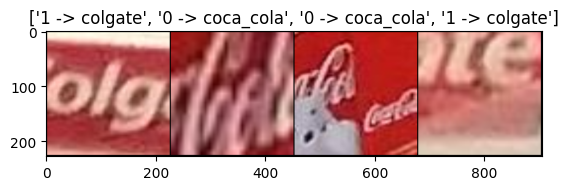

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    #converting input tensor back to 2d image with color channels
    inp = inp.numpy().transpose((1, 2, 0))
    
    #if the images were normalized in the dataset object, unnormalize like this:
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    
    #clip values between 0 and 1
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
img_grid = torchvision.utils.make_grid(inputs)

imshow(img_grid, title=[ (str(x.item()) + " -> " + class_names[x]) for x in classes])

### TensorBoard setup
When you finished this notebook and are in tensorboard: <br>
Look at the scalar tab for training loss and accuracy. <br>
Look at the graph tab to see the model graph and dataflow.

In [5]:
# Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs_ft/sku110k_exp1')

# Write image data to TensorBoard log dir
writer.add_image('one batch of fish images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs_ft
# ...and open a browser tab to http://localhost:6006/

## training

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

<br>
In the code cell below:
- We define the train function which will be the train and validation loop
- We loop over the specified number of epochs
- In each epoch we loop over the data using the dataloaders for train and validation
- We keep the model that had the heighest validation accuracy, because that model has the best generalization  

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #move data on GPU for training/validating on cuda device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #torch.max(outputs,1) returns 
                    #the max values of the ouput tensor (each image's output in this batch is a row in this tensor) 
                    # -> ignore values, store to _
                    #the index of these max values in the output tensor 
                    # -> these are the predictions that correspond to class indicis
                    _, preds = torch.max(outputs, 1)
                    #compare outputs output tensor to label tensor to see how far off the neural net was
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #compute grad
                        loss.backward()
                        #nudge weights based on grad's calculated +(LR*-grad)
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            ########LOGGING LOSS AND ACCURACY TO TENSORBOARD########
            # Log the running loss averaged per batch
            # for both the training phase and the validation phase
            writer.add_scalars(
                f'sku110k',
                {f'{phase} Loss' : epoch_loss, f'{phase} Accuracy' : epoch_acc },
                epoch
            )
            ########################################################

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
    ##########################################
    #making sure tensorboard data is written to disk:
    writer.flush()
    ##########################################    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the predictions

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            #move data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #print the output neuron's index and the predicted class associated with it
                ax.set_title( f'predicted: {preds[j].item()} -> {class_names[preds[j]]}\n GT: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Option 1: Finetuning the ConvNet
If you have already fine tuned the model and saved the weights, skip these cells until "Option 2: Load weights from previous fine tuning"
- adjusting the resnet50 architecture to have an fc with len(class_names) output neurons for classification
- loading the weights from pre-training
- moving model to GPU
- setting up criterion, optimizer, and lr decay scheduler


In [8]:
#downloaded models are sace to users/ovanl/.cache/torch/hub/checkpoints/resnet50.path
model_ft = models.resnet50()

#freezing the weights of the convolutional layers by turning of grad, which means the gradient won't be 
#calculated/tracked anymore with autograd
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
print(f"last layer before adjustment {model_ft.fc} ")

#replacing the final fully connected layer from a 2048,1000 -> 2048,len(class_names)=2
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) #new linear layer has autograd on automatically
print(f"last layer after adjustment {model_ft.fc} ")

#loading the neural network with pretrained weights:
model_ft.load_state_dict( torch.load("resnet50/sku110k/resnet50_ft.pth"))
print("Resnet50 weights loaded from file ")
#saving the current network parameters to a file
#torch.save(model_ft.state_dict(), "resnet50_ft.pth")

#move model to GPU for training on CUDA device
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

last layer before adjustment Linear(in_features=2048, out_features=1000, bias=True) 
last layer after adjustment Linear(in_features=2048, out_features=2, bias=True) 
Resnet50 weights loaded from file 


### Training and evaluation (with validation)
Fine tune the model and save the weights

In [9]:
#only fine tuning lineair classifier layer
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
#saving the current network parameters to a file
torch.save(model_ft.state_dict(), "resnet50/sku110k/resnet50_ft_after.pth")

Epoch 0/24
----------
train Loss: 0.6665 Acc: 0.6304
val Loss: 0.8994 Acc: 0.5333

Epoch 1/24
----------
train Loss: 0.5148 Acc: 0.7826
val Loss: 1.1934 Acc: 0.5333

Epoch 2/24
----------
train Loss: 0.3301 Acc: 0.9130
val Loss: 0.7719 Acc: 0.5333

Epoch 3/24
----------
train Loss: 0.3521 Acc: 0.8261
val Loss: 0.9232 Acc: 0.5333

Epoch 4/24
----------
train Loss: 0.3517 Acc: 0.8478
val Loss: 0.9968 Acc: 0.5333

Epoch 5/24
----------
train Loss: 0.4634 Acc: 0.8261
val Loss: 0.8455 Acc: 0.5333

Epoch 6/24
----------
train Loss: 0.3456 Acc: 0.8261
val Loss: 0.8089 Acc: 0.5333

Epoch 7/24
----------
train Loss: 0.2870 Acc: 0.8913
val Loss: 0.9378 Acc: 0.5333

Epoch 8/24
----------
train Loss: 0.2713 Acc: 0.9130
val Loss: 1.0618 Acc: 0.5333

Epoch 9/24
----------
train Loss: 0.1336 Acc: 1.0000
val Loss: 1.0053 Acc: 0.5333

Epoch 10/24
----------
train Loss: 0.3248 Acc: 0.9130
val Loss: 0.8915 Acc: 0.5333

Epoch 11/24
----------
train Loss: 0.3699 Acc: 0.8478
val Loss: 1.1189 Acc: 0.5333

Ep

## Option 2: Load weights from previous fine tuning
Only execute the cell below if you have done the finetuning before and just want to load the weights instead of train them (again).

In [11]:
model_ft = models.resnet50()

num_ftrs = model_ft.fc.in_features
print(f"last layer before adjustment {model_ft.fc} ")

#replacing the final fully connected layer from a 2048,1000 -> 2048,len(class_names)=2
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
print(f"last layer after adjustment {model_ft.fc} ")

#loading the neural network with pretrained weights:
model_ft.load_state_dict( torch.load("resnet50/sku110k/resnet50_ft_after.pth"))
print("Resnet50 fine tuned weights loaded from file ")

#move model to GPU
if torch.cuda.is_available():
    model_ft.to(torch.device("cuda"))
    print("model moved to cuda device")


last layer before adjustment Linear(in_features=2048, out_features=1000, bias=True) 
last layer after adjustment Linear(in_features=2048, out_features=2, bias=True) 
Resnet50 fine tuned weights loaded from file 
model moved to cuda device


## Testing the model
Compare the predicted label to the ground truth (GT)

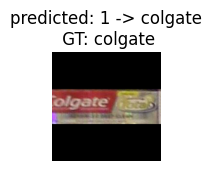

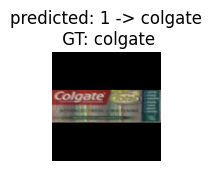

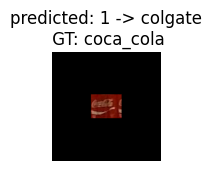

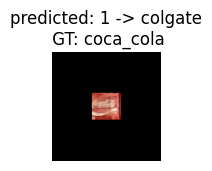

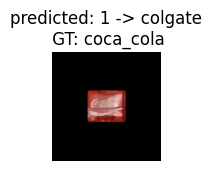

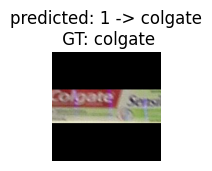

In [10]:
# taking some images from the validation loader and 
# showing the predicted label of our resnet50
# and the ground truth (GT)
visualize_model(model_ft)

In [11]:
# Grab a single mini-batch of images
dataiter = iter(dataloaders['val'])
images, labels = next(dataiter)
#move data to GPU
images = images.to(torch.device("cuda"))
labels = labels.to(torch.device("cuda"))

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(model_ft, images)
writer.flush()

In [12]:
#close the writer 
writer.close()